In [267]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import ChebConv
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import ttest_ind
import networkx as nx

In [268]:
dataset = torch.load('nfl_coaches_subset.pt', weights_only=False)

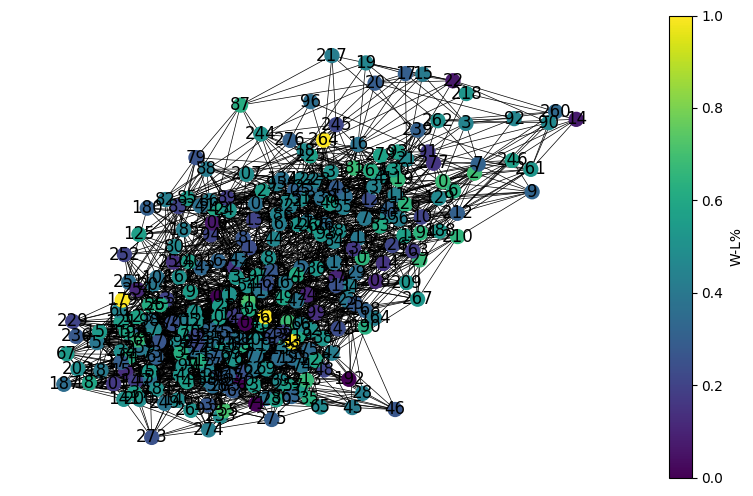

In [269]:
edges = dataset.edge_index.t().numpy()
G = nx.Graph()
G.add_edges_from(edges)

fig, ax = plt.subplots(figsize=(10,6))

pos = nx.spring_layout(G)
nx.draw(G, pos, ax=ax,
        node_color=dataset.x[:,4],
        node_size=100,
        width=0.5,
        with_labels=True,
        cmap=plt.cm.viridis)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=dataset.x[:,4].min(), vmax=dataset.x[:,4].max()))
plt.colorbar(sm, ax=ax, label='W-L%')

plt.show()


In [270]:
class ChebGNN(nn.Module):
    def __init__(self, in_channels, K=3):
        super().__init__()
        self.conv1 = ChebConv(in_channels, 32, K=K)
        self.conv2 = ChebConv(32, 16, K=K)
        self.lin = nn.Linear(16, 1)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.5, training=self.training)
        out = self.lin(x)
        return out.squeeze()
    
class GCN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = torch.nn.Linear(in_channels, 32)
        self.conv2 = torch.nn.Linear(32, 16) 
        self.lin = nn.Linear(16, 1)
        
    def forward(self, x, edge_index):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        out = self.lin(x)
        return out.squeeze()

## mad data leakage in this bih

In [271]:
def train_test_split(dataset, train_ratio=0.8, seed=42):
    torch.manual_seed(seed)
    mask = torch.rand(dataset.x.shape[0]) < train_ratio
    train_mask = mask
    test_mask = ~mask
    train_dataset = dataset.subgraph(train_mask)
    test_dataset = dataset.subgraph(test_mask)
    return train_dataset, test_dataset

In [272]:
train_dataset, test_dataset = train_test_split(dataset)

In [273]:
def run_experiment(train_dataset, test_dataset, model, feature_name='W-L%', plot=False, verbose=False):
    feature_names = ['Yrs', 'G', 'W', 'T', 'W-L%', 'G > .500', 'AvRk', 'BstRk', 'HOF']
    feature_idx = feature_names.index(feature_name)
    
    X_train = train_dataset.x.numpy()
    X_train = torch.tensor(X_train[:,feature_idx].reshape(-1,1))
    edge_index_train = train_dataset.edge_index
    
    X_test = test_dataset.x.numpy() 
    X_test = torch.tensor(X_test[:,feature_idx].reshape(-1,1))
    edge_index_test = test_dataset.edge_index

    y_train = train_dataset.x[:,feature_idx]
    y_test = test_dataset.x[:,feature_idx]

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    train_losses = []

    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(X_train, edge_index_train)
        loss = criterion(out, y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

    if plot:
        plt.figure(figsize=(10,6))
        plt.subplot(1,1,1)
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Prediction of {feature_name}')
        plt.legend()

    model.eval()
    with torch.no_grad():
        out = model(X_test, edge_index_test)
        y_pred = out.numpy()
        y_true = y_test.numpy()
        
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        p_value = ttest_ind(y_true, y_pred, alternative='greater').pvalue
        
        if plot:
            plt.figure(figsize=(10,6))
            plt.scatter(y_true, y_pred, alpha=0.5)
            plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
            plt.xlabel('Actual ' + feature_name )
            plt.ylabel('Predicted ' + feature_name)
            plt.title('Actual vs Predicted ' + feature_name + ' on Test Set')
            plt.tight_layout()
            plt.show()
        
        if verbose:
            print(f"Test Set Evaluation for {feature_name}:")
            print(f"Mean Squared Error: {mse:.4f}")
            print(f"r2 Score: {r2:.4f}")
            
            print("Sample Predictions:")
            print("Actual\tPredicted")
            for actual, pred in zip(y_true[:5], y_pred[:5]):
                print(f"{actual:.3f}\t{pred:.3f}")
            
        return mse, r2, p_value


torch.Size([280, 9])


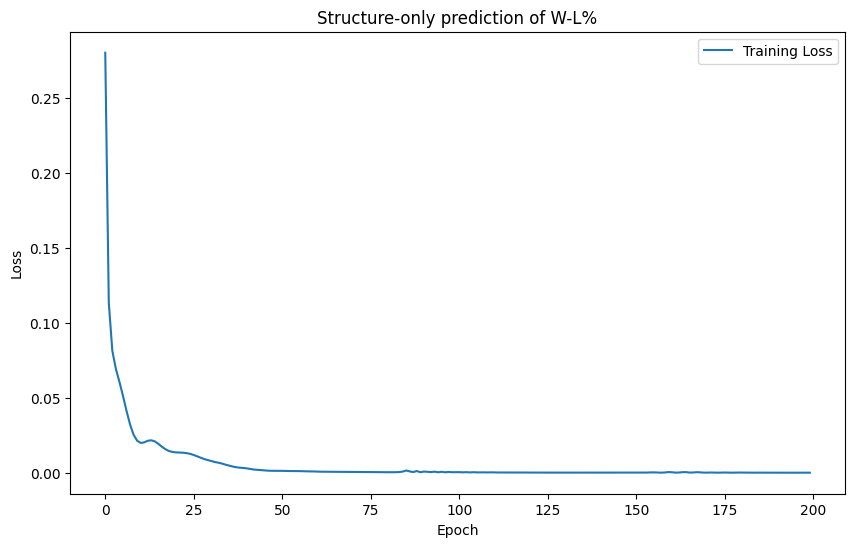

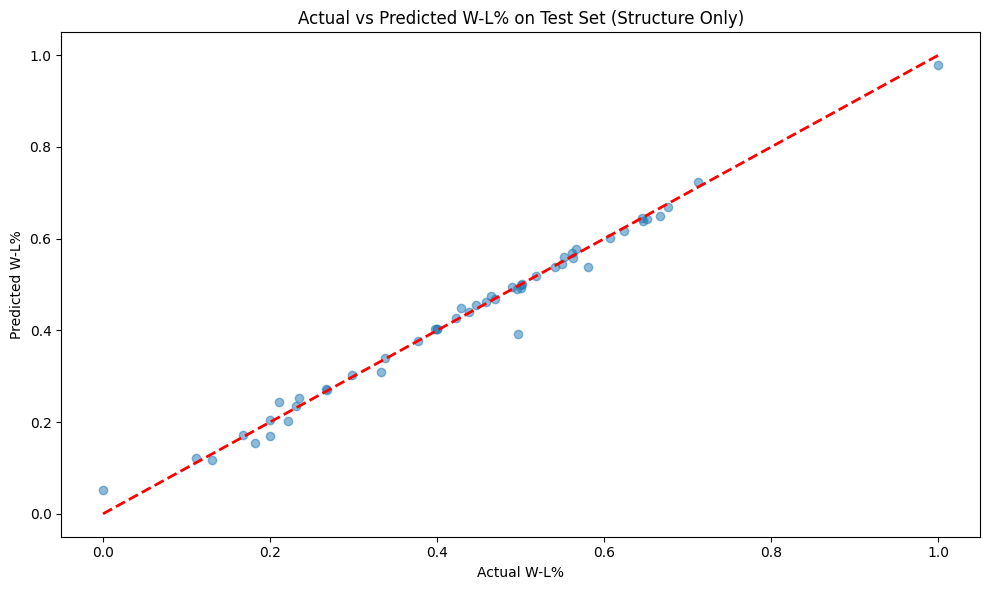

Test Set Evaluation for W-L%:
Mean Squared Error: 0.0004
r2 Score: 0.9874
Sample Predictions:
Actual	Predicted
0.677	0.668
0.566	0.578
0.447	0.456
0.268	0.270
0.200	0.170


(0.00044289600919000804, 0.9874464273452759, 0.47373176646553333)

In [274]:
model = ChebGNN(1)

print(dataset.x.shape)
run_experiment(model = model, feature_name='W-L%', train_dataset=train_dataset, test_dataset=test_dataset, plot=True, verbose=True)

In [275]:
model = ChebGNN(1)
mse_list = []
r2_list = []
p_value_list = []
for i in range(10): 
    train_dataset, test_dataset = train_test_split(dataset, seed = i)
    mse, r2, p_value= run_experiment(model = model, feature_name='W-L%', train_dataset=train_dataset, test_dataset=test_dataset, plot=False, verbose=False)
    mse_list.append(mse)
    r2_list.append(r2)
    p_value_list.append(p_value)

# I forgot what p val and r2 are but I printed them anyway
# pval looks bad but r2 is good so idk 
print(f"Mean MSE: {np.mean(mse_list):.4f}, Std MSE: {np.std(mse_list):.4f}")
print(f"Mean R2: {np.mean(r2_list):.4f}, Std R2: {np.std(r2_list):.4f}")
print(f"Mean P-value: {np.mean(p_value_list):.4f}, Std P-value: {np.std(p_value_list):.4f}")

Mean MSE: 0.0002, Std MSE: 0.0002
Mean R2: 0.9931, Std R2: 0.0082
Mean P-value: 0.5219, Std P-value: 0.0255
